In [1]:
# Enables all Deep Learning Tools.
from arcgis.learn import *

# Classes and analysis functions for working with raster data and imagery layers
from arcgis.raster import ImageryLayer

# Access to the GIS services using Python
from arcgis.gis import GIS

# ArcGis environment for developing Python scripts 
from arcpy import *
from arcpy.sa import *
from arcpy.ia import *

# Requests allows us to send HTTP/1.1 requests extremely easily.
import requests

# This module allows us to manage warning.  We chose to disable them to enhance readability.
import warnings
warnings.filterwarnings('ignore')

# The multiprocessing package side steps the Global Interpreter Lock by using subprocesses instead of threads.
# Due to this, the multiprocessing module allows us to fully leverage multiple processors on a given machine.
import multiprocessing

# Target file path
SourceTile = r"U:\ProjectData\027-15_2018a_4BAND.TIF"

# Retrieves the license from the License Manager
arcpy.CheckOutExtension("ImageAnalyst")

'CheckedOut'

In [2]:
""" This function trains a Deep Learning Model, saves it and returns a classified raster.

Parameters:
    mynet:a Classifier object
    myiterations: an integer which represents the number of epochs the classifier will be trained for
    mytpye: a string which is used to save and retrieve the function output to/from the correct path

"""

def AClassifier(mynet, myiterations, mytype):
      
    # The best learning rate for the model is calculated.
    best_rate = mynet.lr_find()
    
    # Trains the model for the specified number of epochs.
    mynet.fit(myiterations, best_rate)
    
    # Builds strings to save the trained model, locate the necessary dlpk file, and create the classified raster
    modelpath = r"U:\\ProjectData\\Models\\" + mytype
    model_folder= modelpath + "\\" + mytype + ".dlpk"
    ClassifiedRaster = r"U:\\ProjectData\\ClassifiedRaster" + mytype + ".tif"
    
    # Save model
    mynet.save(modelpath, framework='PyTorch', publish=True, gis=None, compute_metrics=True, save_optimizer=True, save_inference_file=True)
    
    # Returns the classified raster
    return ClassifyPixelsUsingDeepLearning(inRaster, model_folder)
    

The aim of this project was to identify areas of mixed land cover on orthophotography 4-band raster data (RGB + near infrared) using new-generation deep learning implementations.
Deep learning is a type of machine learning with several layers of nonlinear processing which allow users to identify patterns, objects, and pixels through models. It is a significant improvement on previous Machine Learning systems since it does not require vast amounts of training samples produced by expert users. Several ArcGis Pro Deep Learning models support sparse training data with remarkable success. In this project, training data for our models was gathered in intervals of less than 30.

There are several different algorithms and deep learning models that can be employed for image classification.  This project is a tool to carry out image classification of land cover by preprocessing target data, exporting training samples, training and evaluating deep learning models, and displaying results so a human operator can then choose the best fitting model.

# 0 - Enable GPU and Parallelism

In [3]:
# Instruct ArcGis Pro to use GPU acceleration for faster processing
arcpy.env.processorType = "GPU"

# Execution of this task is split among 8 (50% x number of cores) processes to speed it up as it can be extremely resource - intensive
arcpy.env.parallelProcessingFactor = '50%'

# 1 - Preprocessing

Firstly, we transform our target file into a raster object.

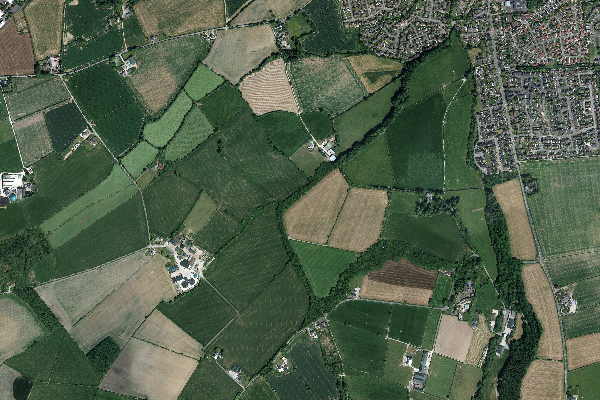

In [4]:
Source_Raster = Raster(SourceTile)
Source_Raster

## Sharpen

Then, we smooth the target image using  convolution, in order to enhance it with a sharpening 5 X 5 filter.

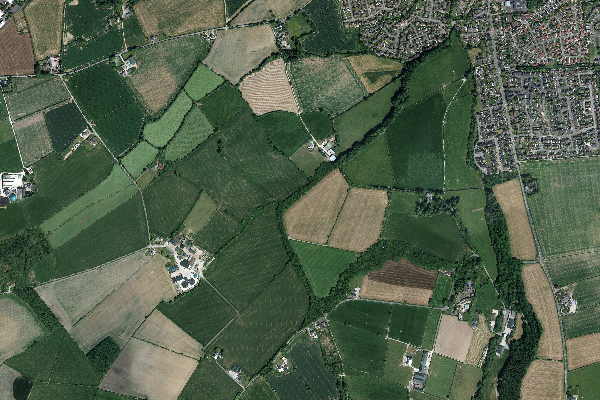

In [5]:
# The parameter '14' identifies the 5x5 filter required 

Smooth_Raster = arcpy.sa.Convolution(Source_Raster, 14)
Source_Raster.save()
Source_Raster

## Stretch
The next preprocessing stage consists of enhancing an image by changing properties such as brightness, contrast, and gamma. In this case, we use a Sigmoid stretch as it highlights moderate pixel values while maintaining sufficient contrast in the perimeter.

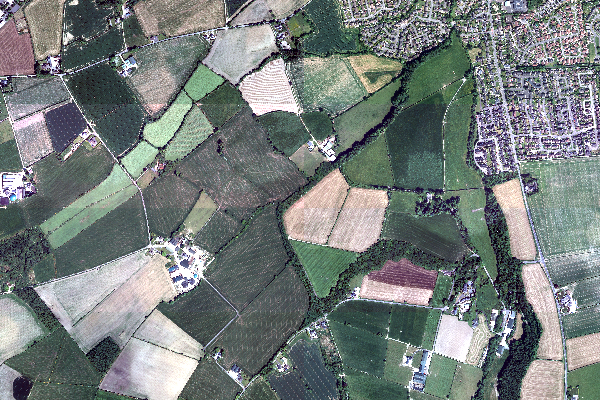

In [6]:
# "3" indicates the sigmoid strength level. The minimum value is 0, and the maximum value is 6.

Stretched_Raster = arcpy.sa.Stretch(Source_Raster, "StdDev", 0, 255, 2, None, True, None, None, None, None, 3)
Stretched_Raster

## Resample

Resampling changes the spatial resolution of a raster dataset and sets rules for aggregating or interpolating values across the new pixel size.  In this case, we will resample the image according to our datase spatial resolution (40 cm) and we will use the "Nearest" resampling technique, which is suitable for land cover and discrete data.

In [7]:
Str_Output_Raster = r"U:\\ProjectData\\resampled_output.tif"
arcpy.management.Resample(Stretched_Raster, Str_Output_Raster, 0.4, "Nearest")
Resampled_Raster = Raster(Str_Output_Raster)

## Segmentation

Segmentation allows us to identify objects, features, or segments by grouping adjacent pixels with similar spectral and spatial characteristics. The parameters used are spectral detail = 18, spatial detail = 3, minimum segment size = 25.

In [ ]:
Segmented_Raster = SegmentMeanShift(Resampled_Raster, 18, 3, 25)
Segmented_Raster.save()

## Check raster type and number of bands

Some deep learning algorithms are only able to operate on 3-band raster files.  Hence, this cell checks the the number of bands in the target raster and, if it detects that there are more than 3 bands, it will extract the first 3.  It assumes a certain RGB order, and that the band to be omitted is the 4th band.  This matches related data and project requirements but might differt in other environments

In [ ]:
# Gets the band count and value type of the preprocessed raster. Creates string to output the raster after saving.

Str_Raster_Features_BAND  = arcpy.management.GetRasterProperties(Segmented_Raster, "BANDCOUNT")
Str_Raster_Features_VALUETYPE  = arcpy.management.GetRasterProperties(Segmented_Raster, "VALUETYPE")
Str_Output_Raster = r"U:\\ProjectData\\ThreeBand8Bit_Raster.tif"

# Extracts bands 1, 2 and 3 if bandcount > 3

if (Str_Raster_Features_BAND.getOutput(0) > '3'):
    Resampled_Raster = arcpy.ia.ExtractBand(Resampled_Raster, [1, 2, 3])

# Copies the result into a 8 bit unsigned, 3 band raster

arcpy.management.CopyRaster(Segmented_Raster, Str_Output_Raster, "", "", "", "NONE", "NONE", "8_BIT_UNSIGNED", "NONE", "NONE", "TIFF", "NONE", "","")

# 2 - Export Training Data 

The second stept in our pixel classification journey is to export our training data.

In [ ]:
# Definition of values for Export Training Data for Deep Learning

# The target raster file we want to analyse

inRaster = r"U:\\ProjectData\ThreeBand8Bit_Raster.tif"

# The folder which will contain samples and labels produced by the exporting process.

out_folder = r"U:\\ProjectData\ChipsAndLabels"

# Feature class saved from ArcGis Pro outside this project, using the Label Objects for Deep Learning menu

in_training = r"U:\\ProjectData\training.shp"

# Other parameters for ExportTrainingDataForDeepLearning. Classified_Tiles is the key value which tells the function
# to prepare data for pixel classification Deep Learning models

image_chip_format = "TIFF"
tile_size_x = "256"
tile_size_y = "256"
stride_x= "128"
stride_y= "128"
output_nofeature_tiles= "ONLY_TILES_WITH_FEATURES"
metadata_format= "Classified_Tiles"
start_index = 0
classvalue_field = "Classvalue"

This function uses the feature class of training samples obtained through ArcGis Pro's **Label Objects For Deep Learning** to create two folders which will be used by our Deep Learning model: a folder with image samples (chips) and a folder with labels.

In [ ]:
ExportTrainingDataForDeepLearning(inRaster, out_folder, in_training, image_chip_format,tile_size_x, tile_size_y,stride_x,
                                  stride_y,output_nofeature_tiles,metadata_format, start_index,classvalue_field)

# 3 - Train classifiers

Next, we prepare the Chips and Labels for the Deep Learning model.  In this funtion, batch_size determines the number of training samples to be processed for training at one time. The default value is 2.  The higher the value, the quicker the processing. Values which exceed the computer capabilities will return **out of memory** errors.

In [ ]:
data = prepare_data(out_folder, batch_size = 8)

U-NET and PSPNET modesl are trained using the chips and labels in the data object. **Ignore_classes** is a critical parameter here.  It contains the list of class values on which the model will not incur loss. It requires a value of 0 for the model to run successfully because the NoData class is mapped to '0'.

In [ ]:
# Creates a U-Net Classifier object 

unet = UnetClassifier(data, backbone='resnet34', class_balancing = 'False', mixup= 'False', focal_loss = 'False', ignore_classes=[0], chip_size=224, monitor = 'valid_loss')

# Creates a PSPNet Classifier object 

psp = PSPNetClassifier(data=data, use_unet=False)

# 4 - Classify

The 2 classifiers are passed on to the custom-built **AClassifier** function. In **AClassifier**, classifiers are trained and the pixel classification is carried out.

In [ ]:
unet_classified = AClassifier(unet, 20, 'UNET')
psp.per_class_metrics()

In [14]:
psp_classified = AClassifier(psp, 20, 'PSPNET')
psp.per_class_metrics()

epoch     train_loss  valid_loss  time    
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

# 5 - Conclussions

Finally, both U-Net and PSPNet classified rasters are saved and displayed, which allows to visually verify the results obtained above.  In this exmaple, U-Net provides far better results than PSPNet.

In [ ]:
# Saves and displays U-Net classified raster

unet_classified.save()
unet_classified

In [ ]:
# Saves and displays PSPNet classified raster

psp_classified.save()
psp_classified